In [1]:
%matplotlib inline
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

print("TF version: ", tf.__version__)
print("Keras version: ", keras.__version__)

TF version:  2.6.0
Keras version:  2.6.0


In [2]:
gr = (1+5**0.5) / 2
dist = gr**0.5/gr**2 * gr/gr**6

In [4]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_dev, y_dev) = mnist.load_data()

rescale = keras.layers.Rescaling(1/255.)

X_train = tf.reshape(rescale(X_train), shape=(-1, 28, 28, 1))
X_dev = tf.reshape(rescale(X_dev), shape=(-1, 28, 28, 1))

transformations = keras.Sequential([
    layers.RandomRotation(dist),
    layers.RandomTranslation(dist, dist),
    layers.RandomZoom((-dist*3, dist*3)),
])

X_train_transformed = transformations(X_train)
X_dev_transformed = transformations(X_dev)

print(X_train.shape, X_dev.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [5]:
def plot_img(img: np.array, label: int):
    print('Number:', label)
    plt.imshow(img.squeeze(), cmap='Greys_r')

Number: 9


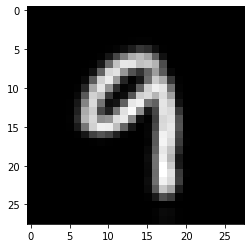

In [11]:
n = np.random.randint(X_train_transformed.shape[0])
plot_img(X_train_transformed[n].numpy(), y_train[n])

In [12]:
model = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dropout(rate=0.1),
    layers.Dense(units=10, activation='softmax')
])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)              

In [13]:
hist = model.fit(X_train_transformed, y_train,
    batch_size=32, epochs=15,
    validation_data=(X_dev_transformed, y_dev)
)

Epoch 1/15
1875/1875 [==============================] - 39s 5ms/step - loss: 0.4561 - accuracy: 0.8554 - val_loss: 0.1302 - val_accuracy: 0.9601
Epoch 2/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1687 - accuracy: 0.9478 - val_loss: 0.0863 - val_accuracy: 0.9724
Epoch 3/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1271 - accuracy: 0.9610 - val_loss: 0.0644 - val_accuracy: 0.9790
Epoch 4/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1028 - accuracy: 0.9680 - val_loss: 0.0539 - val_accuracy: 0.9839
Epoch 5/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0900 - accuracy: 0.9717 - val_loss: 0.0464 - val_accuracy: 0.9855
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0786 - accuracy: 0.9755 - val_loss: 0.0435 - val_accuracy: 0.9865
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0720 - accuracy: 0.9773 - val_loss: 0.0390 - val_accur

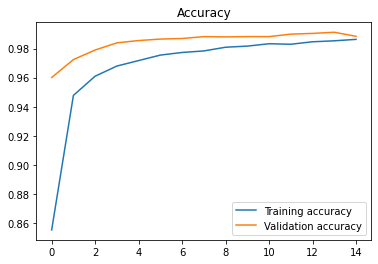

In [14]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

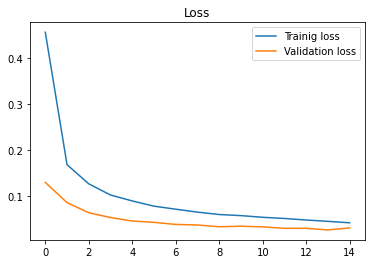

In [15]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

In [16]:
p_dev = np.argmax(model.predict(X_dev), axis=1)
p_train = np.argmax(model.predict(X_train), axis=1)

In [17]:
print("DEV F1 SCORE: ", f1_score(y_dev, p_dev, average='weighted'))
print("TRAIN F1 SCORE: ", f1_score(y_train, p_train, average='weighted'))

DEV F1 SCORE:  0.9940008910492881
TRAIN F1 SCORE:  0.9936183829137606


DEV CONFUSION MATRIX:


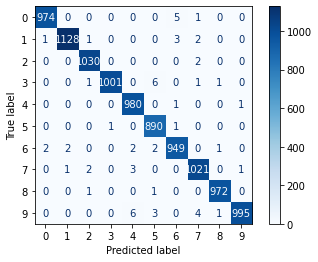

In [18]:
print("DEV CONFUSION MATRIX:")
cm = confusion_matrix(y_dev, p_dev)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(0, 10))
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation='horizontal', values_format='');

**TODO:**   
1. anomaly detection / outlier removal
2. Retrain the net with better data
3. test the network with external data
4. if succesful save the net and load in the web app, else repeat the steps again

In [19]:
p_train_logits = model.predict(X_train)

In [20]:
def clean_dataset(X, y, y_pred_logits, clean_percent: float = 0.01):
    N_TO_REMOVE = round(X.shape[0] * clean_percent)
    max_accuracies_array = np.array(y_pred_logits.max(axis=1))
    X_ = X.tolist()
    y_ = y.tolist()
    all_concat = list(zip(X_, y_, max_accuracies_array.tolist()))
    all_concat.sort(key=lambda x: x[2])
    X_new, y_new, _ = zip(*all_concat[N_TO_REMOVE:])
    return np.array(X_new), np.array(y_new)

In [22]:
X_train_clean, y_train_clean = clean_dataset(X_train_transformed.numpy(), y_train, p_train_logits, 0.001)
X_train_clean.shape, y_train_clean.shape

((59940, 28, 28, 1), (59940,))

Number: 6


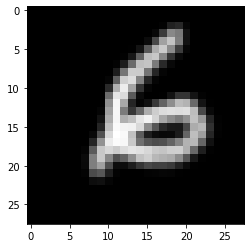

In [23]:
plot_img(X_train_clean[n], y_train_clean[n])

In [37]:
model2 = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dropout(rate=0.08),
    layers.Dense(units=10, activation='softmax')
])

model2.compile(
    optimizer=tf.optimizers.Adam(0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [38]:
hist2 = model2.fit(X_train_clean, y_train_clean, 
                   batch_size=32, epochs=15, validation_data=(X_dev_transformed, y_dev))

Epoch 1/15
1874/1874 [==============================] - 11s 5ms/step - loss: 0.4648 - accuracy: 0.8524 - val_loss: 0.1535 - val_accuracy: 0.9531
Epoch 2/15
1874/1874 [==============================] - 10s 5ms/step - loss: 0.1876 - accuracy: 0.9407 - val_loss: 0.0908 - val_accuracy: 0.9720
Epoch 3/15
1874/1874 [==============================] - 10s 5ms/step - loss: 0.1389 - accuracy: 0.9566 - val_loss: 0.0677 - val_accuracy: 0.9783
Epoch 4/15
1874/1874 [==============================] - 10s 5ms/step - loss: 0.1153 - accuracy: 0.9635 - val_loss: 0.0622 - val_accuracy: 0.9814
Epoch 5/15
1874/1874 [==============================] - 10s 5ms/step - loss: 0.0958 - accuracy: 0.9699 - val_loss: 0.0559 - val_accuracy: 0.9822
Epoch 6/15
1874/1874 [==============================] - 10s 5ms/step - loss: 0.0856 - accuracy: 0.9729 - val_loss: 0.0475 - val_accuracy: 0.9840
Epoch 7/15
1874/1874 [==============================] - 10s 5ms/step - loss: 0.0787 - accuracy: 0.9750 - val_loss: 0.0446 - val_ac

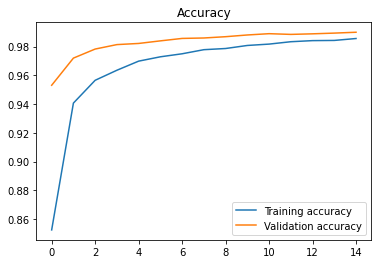

In [39]:
plt.title('Accuracy')
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

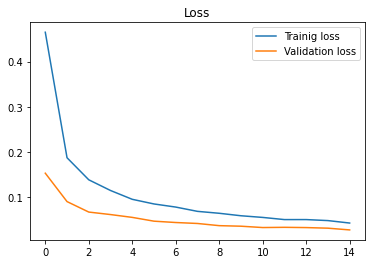

In [40]:
plt.title('Loss')
plt.plot(hist2.epoch, hist2.history['loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

## Analysing the models

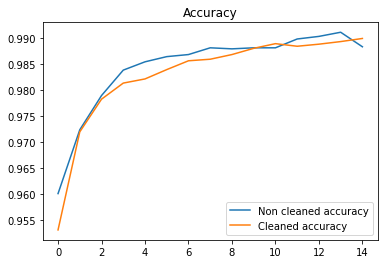

In [41]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Non cleaned accuracy', 'Cleaned accuracy'])
plt.show();

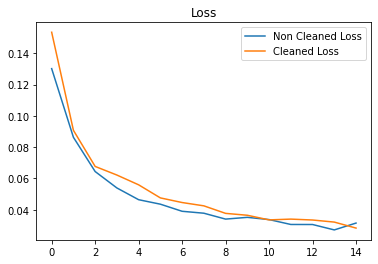

In [42]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['val_loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Non Cleaned Loss', 'Cleaned Loss'])
plt.show();

In [43]:
print("Non cleaned F1 Score:", f1_score(y_dev, np.argmax(model.predict(X_dev), axis=1), average='weighted'))
print("Cleaned F1 Score:", f1_score(y_dev, np.argmax(model2.predict(X_dev), axis=1), average='weighted'))

Non cleaned F1 Score: 0.9940008910492881
Cleaned F1 Score: 0.9947997981569144


In [33]:
one = tf.constant([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16326458752155304, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0.5714263319969177, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285658299922943, 1, 1, 0.4897943437099457, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24489717185497284, 1, 1, 1, 0, 1, 1, 0.14286039769649506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9996798634529114, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20408114790916443, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4285736083984375, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9983993172645569, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.5918376445770264, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.28571316599845886, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9990395307540894, 0.7543814182281494, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], shape=(1, 28, 28, 1))

Number: 1


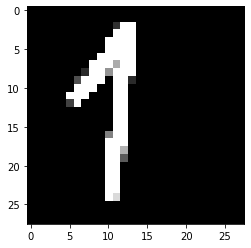

In [34]:
plot_img(one.numpy(), 1)

In [44]:
p = model.predict(one)
print(p.max())
np.argmax(p)

0.99609864


1

In [45]:
p = model2.predict(one)
print(p.max())
np.argmax(p)

0.9979499


1

In [46]:
model2.save('./DigitModel.h5')